In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [5]:
# read in data
# already performed ADF test and confirmed data is stationary
cpu_util = pd.read_csv("/Users/christinetsai/Desktop/ds4002/02-time-series-project/ds4002-project2/DATA/ec2_cpu_utilization_53ea38.csv")
cpu_util.head()

,timestamp,value
0,2014-02-14 14:30:00,1.732
1,2014-02-14 14:35:00,1.732
2,2014-02-14 14:40:00,1.960
3,2014-02-14 14:45:00,1.732
4,2014-02-14 14:50:00,1.706


Anomaly Detection Using ARIMA
- steps:
    - check for stationarity
    - fit time series model to preprocessed data
    - find squared error for each observation
    - find threshold for errors in data
    - find anomalies: compare observed time series values w/ values predicted by ARIMA model. If the difference exceeds some threshold, flag that observation as an anomaly 
- p = number of laged observations
- d = order of differencing
- q = order of the moving avg part 

In [ ]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(cpu_util["value"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
cpu_util['val_diff'] = cpu_util['value'].diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(cpu_util["val_diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Original): -9.8419
p-value (Original): 0.0000
Interpretation: The original series is Stationary.

ADF Statistic (Differenced): -17.2580
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


In [6]:
!pip install prophet


In [7]:
# rename cols to be compatible w/ prophet
cpu_util.rename(columns={'timestamp': 'ds', 'value': 'y'}, inplace=True)



In [8]:
from prophet import Prophet

def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
   m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
               seasonality_mode = 'additive',
               interval_width = interval_width,
               changepoint_range = changepoint_range)
   print("m: ", m)
   m = m.fit(dataframe)
   forecast = m.predict(dataframe)
   print("forecast: ", forecast)
   forecast['fact'] = dataframe['y'].reset_index(drop = True)
   return forecast

pred = fit_predict_model(cpu_util)

# push pred variable to another function
def detect_anomalies(forecast):
   forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
   forecasted['anomaly'] = 0
   forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
   forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
#anomaly importances
   forecasted['importance'] = 0
   forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
   forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
   return forecasted

pred = detect_anomalies(pred)

11:06:12 - cmdstanpy - INFO - Chain [1] start processing
11:06:12 - cmdstanpy - INFO - Chain [1] done processing


m:  <prophet.forecaster.Prophet object at 0x178b29e50>
forecast:                        ds     trend  yhat_lower  yhat_upper  trend_lower  \
0    2014-02-14 14:30:00  1.818194    1.527090    2.081661     1.818194   
1    2014-02-14 14:35:00  1.818185    1.526845    2.064147     1.818185   
2    2014-02-14 14:40:00  1.818177    1.584276    2.075043     1.818177   
3    2014-02-14 14:45:00  1.818168    1.542209    2.072955     1.818168   
4    2014-02-14 14:50:00  1.818159    1.548408    2.051809     1.818159   
...                  ...       ...         ...         ...          ...   
4027 2014-02-28 14:05:00  1.821644    1.538440    2.093226     1.821644   
4028 2014-02-28 14:10:00  1.821625    1.566455    2.100874     1.821625   
4029 2014-02-28 14:15:00  1.821606    1.578940    2.079811     1.821606   
4030 2014-02-28 14:20:00  1.821587    1.567087    2.072711     1.821587   
4031 2014-02-28 14:25:00  1.821567    1.570279    2.077243     1.821567   

      trend_upper  additive_terms

In [9]:
pred["anomaly"].sum() # got non-zero value, so it was able to flag some observations as anomalies

56

In [19]:
import matplotlib.pyplot as plt

def plot_forecast(pred):
    plt.figure(figsize=(12, 6))
    
    # Plot the actual values
    plt.plot(pred['ds'], pred['fact'], 'k.', label='Actual values')
    
    # Plot the predicted yhat values
    plt.plot(pred['ds'], pred['yhat'], color='navy', label='Forecast')
    
    # Plot upper and lower bounds
    plt.fill_between(pred['ds'], pred['yhat_lower'], pred['yhat_upper'], color='lightblue', alpha=0.5, label='Confidence interval')
    
    # Highlight anomalies
    anomalies = pred[pred['anomaly'] != 0]
    plt.scatter(anomalies['ds'], anomalies['fact'], color='red', label='Anomalies', zorder=5)
    return plt
    


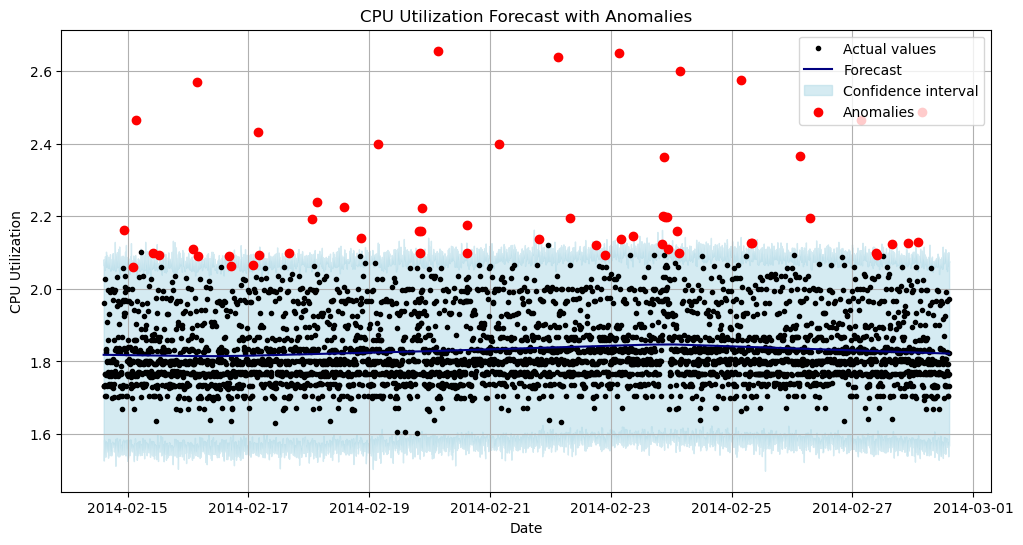

In [20]:
# Call the plot function
cpu_util_plot = plot_forecast(pred)
cpu_util_plot.xlabel('Date')
cpu_util_plot.ylabel('CPU Utilization')
cpu_util_plot.title('CPU Utilization Forecast with Anomalies')
cpu_util_plot.legend()
cpu_util_plot.grid()
cpu_util_plot.show()

In [11]:
network_in = pd.read_csv("/Users/christinetsai/Desktop/ds4002/02-time-series-project/ds4002-project2/DATA/ec2_network_in_5abac7.csv")

network_in.head()

,timestamp,value
0,2014-03-01 17:36:00,42.0
1,2014-03-01 17:41:00,94.8
2,2014-03-01 17:46:00,42.0
3,2014-03-01 17:51:00,68.4
4,2014-03-01 17:56:00,68.4


In [12]:
# rename cols to be compatible w/ prophet
network_in.rename(columns={'timestamp': 'ds', 'value': 'y'}, inplace=True)



In [13]:
network_in_pred = fit_predict_model(network_in)
network_in_pred = detect_anomalies(network_in_pred)

11:08:20 - cmdstanpy - INFO - Chain [1] start processing
11:08:20 - cmdstanpy - INFO - Chain [1] done processing


m:  <prophet.forecaster.Prophet object at 0x1798c35d0>
forecast:                        ds         trend    yhat_lower    yhat_upper  \
0    2014-03-01 17:36:00  19883.268062 -1.836599e+06  2.007852e+06   
1    2014-03-01 17:41:00  19986.419876 -1.955834e+06  2.086454e+06   
2    2014-03-01 17:46:00  20089.571691 -1.982869e+06  1.847172e+06   
3    2014-03-01 17:51:00  20192.723505 -2.043489e+06  2.086248e+06   
4    2014-03-01 17:56:00  20295.875320 -1.938551e+06  1.862563e+06   
...                  ...           ...           ...           ...   
4725 2014-03-18 03:21:00  47126.584151 -1.983351e+06  2.052708e+06   
4726 2014-03-18 03:26:00  47028.881104 -1.931420e+06  2.186147e+06   
4727 2014-03-18 03:31:00  46931.178058 -2.159784e+06  1.956804e+06   
4728 2014-03-18 03:36:00  46833.475011 -1.932868e+06  1.931759e+06   
4729 2014-03-18 03:41:00  46735.771964 -1.760319e+06  1.875600e+06   

       trend_lower   trend_upper  additive_terms  additive_terms_lower  \
0     19883.268062 

In [14]:
network_in_pred["anomaly"].sum()

83

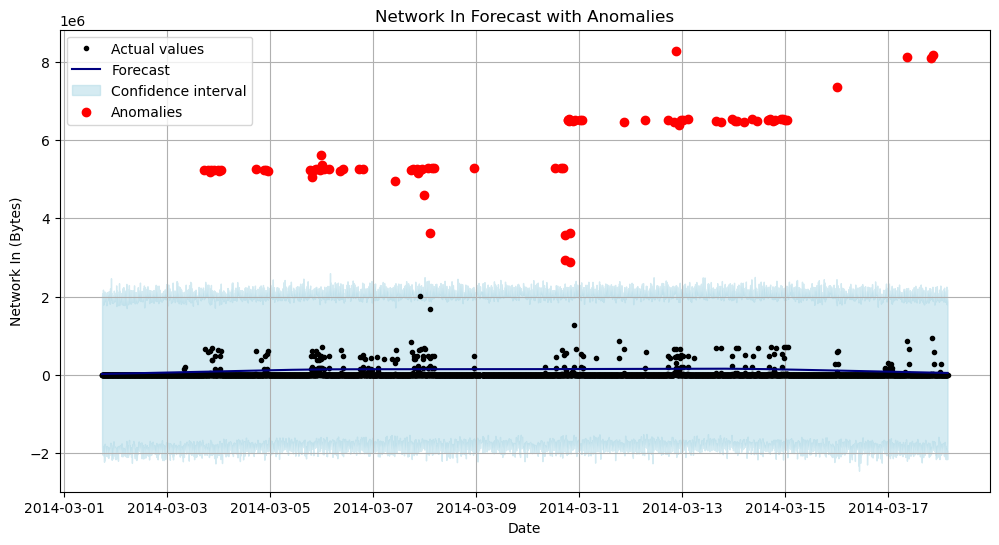

In [18]:
p = plot_forecast(network_in_pred)
p.xlabel('Date')
p.ylabel('Network In (Bytes)')
p.title('Network In Forecast with Anomalies')
p.legend()
p.grid()
p.show()

In [21]:
request_count = pd.read_csv("/Users/christinetsai/Desktop/ds4002/02-time-series-project/ds4002-project2/DATA/elb_request_count_8c0756.csv")
request_count.head()

,timestamp,value
0,2014-04-10 00:04:00,94.0
1,2014-04-10 00:09:00,56.0
2,2014-04-10 00:14:00,187.0
3,2014-04-10 00:19:00,95.0
4,2014-04-10 00:24:00,51.0


In [ ]:
# rename cols to be compatible w/ prophet
request_count.rename(columns={'timestamp': 'ds', 'value': 'y'}, inplace=True)


In [23]:
request_count_pred = fit_predict_model(request_count)
request_count_pred = detect_anomalies(request_count_pred)

11:12:57 - cmdstanpy - INFO - Chain [1] start processing
11:12:57 - cmdstanpy - INFO - Chain [1] done processing


m:  <prophet.forecaster.Prophet object at 0x1798bb650>
forecast:                        ds      trend  yhat_lower  yhat_upper  trend_lower  \
0    2014-04-10 00:04:00  70.876208  -67.498603  209.645874    70.876208   
1    2014-04-10 00:09:00  70.861529  -69.284650  219.492686    70.861529   
2    2014-04-10 00:14:00  70.846850  -60.670735  225.299154    70.846850   
3    2014-04-10 00:19:00  70.832171  -79.981268  213.761405    70.832171   
4    2014-04-10 00:24:00  70.817492  -64.916873  217.095720    70.817492   
...                  ...        ...         ...         ...          ...   
4027 2014-04-24 00:19:00  79.668044  -62.711736  226.039910    79.668044   
4028 2014-04-24 00:24:00  79.702306  -55.022056  230.515716    79.702306   
4029 2014-04-24 00:29:00  79.736567  -62.294688  210.718234    79.736567   
4030 2014-04-24 00:34:00  79.770829  -69.462425  202.176385    79.770829   
4031 2014-04-24 00:39:00  79.805090  -55.475305  221.804848    79.805090   

      trend_upper  ad

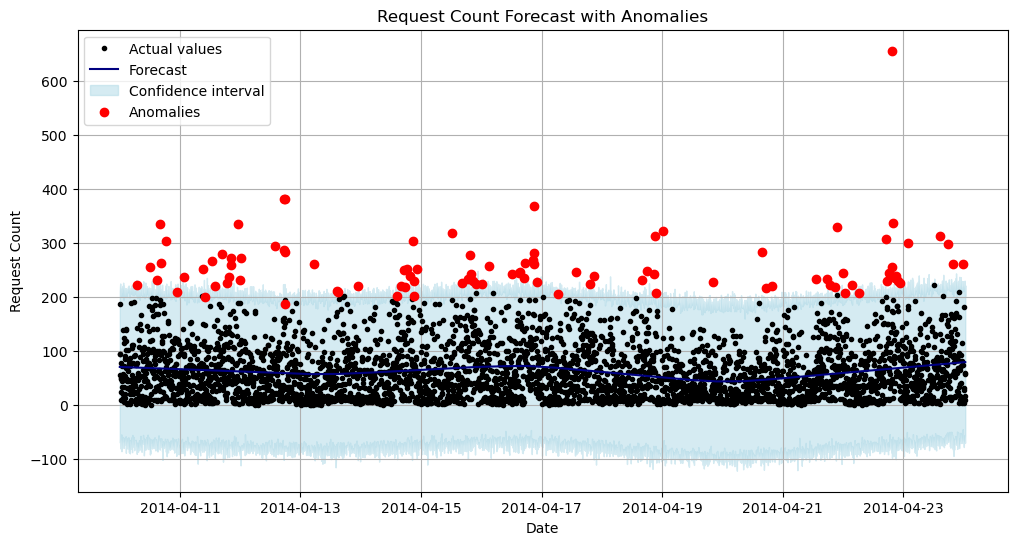

In [24]:
# Call the plot function
request_count_plot = plot_forecast(request_count_pred)
request_count_plot.xlabel('Date')
request_count_plot.ylabel('Request Count')
request_count_plot.title('Request Count Forecast with Anomalies')
request_count_plot.legend()
request_count_plot.grid()
request_count_plot.show()